In [33]:
import numpy as np # Librería de métodos numéricos
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import random

# Lower and upper triangular matrices for linear systems

$$
\left[
\begin{matrix}
\ell_{11}& 0& \cdots & 0\\
\ell_{21}&\ell_{22} & &0\\
\vdots & \vdots & \ddots & \vdots \\
\ell_{n1}&\ell_{n2}&\cdots&\ell_{nn}
\end{matrix}
\right]
\left[
\begin{matrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{matrix}
\right] 
=
\left[
\begin{matrix}
b_1 \\
b_2 \\
\vdots\\
b_n
\end{matrix}
\right] 
\quad\quad\quad
\left[
\begin{matrix}
\ell_{11}&\ell_{12}&\cdots&\ell_{1n}\\
0&\ell_{22}&\cdots& \ell_{2n}\\
\vdots&\vdots &\ddots &\vdots\\
0&0&\cdots&\ell_{nn}
\end{matrix}
\right]
\left[
\begin{matrix}
x_1 \\
x_2 \\
\vdots\\
x_n
\end{matrix}
\right] 
=
\left[
\begin{matrix}
b_1 \\
b_2 \\
\vdots\\
b_n
\end{matrix}
\right]
$$

## Progressive substitution

In [13]:
def s_prog(L,b):
    # s_prog solves the system Lx = b
    # Inputs
    #       L: n-by-n Lower triangular matrix
    #       b: n-by-1 coefficient vector
    # Outputs
    #       x: n-by-1 solution vector
    n = np.shape(L)[0]
    x = np.zeros([n,1])
    for i in np.arange(0,n):
        s=0
        for k in np.arange(0,i):
            s = s + x[k,0]*L[i,k]
        x[i,0]=(b[i,0]-s)/L[i,i]
    return x

### Test

In [14]:
L=np.tril(np.random.rand(5,5))
b=np.ones([5,1])
x=s_prog(L,b)
print(x)

[[ 1.22661713]
 [ 1.03499576]
 [-2.08899607]
 [ 2.49853993]
 [-1.26240074]]


## Regressive substitution

In [15]:
def s_regre(L,b):
    # s_regre solves the system Ux = b
    # Inputs
    #       U: n-by-n Upper triangular matrix
    #       b: n-by-1 coefficient vector
    # Outputs
    #       x: n-by-1 solution vector
    n = np.shape(L)[0]
    x = np.zeros([n,1])
    for i in np.arange(0,n):
        s=0
        j = (n-1) - i
        for k in np.arange(0,i):
            l = j+1+k
            s = s + x[l,0]*L[j,l]
        x[j,0]=(b[j,0]-s)/L[j,j]
    return x

### Test

In [16]:
U=np.triu(np.random.rand(5,5))
b=np.ones([5,1])
x=s_regre(U,b)
print(x)

[[ 15.32192561]
 [  0.88136687]
 [ 12.38019334]
 [-15.90146759]
 [  6.05907031]]


## Jacobi

$$Ax = b$$

where the matrix A can be decomposed into a lower triangular matrix $L$, a diagonal matrix $D$, and an upper triangular matrix $U$ as follows:

$$A = L+D+U$$

The iterative solution vector becomes:

$$x^{k+1}= -D^{-1}(L+U)x^{k}+ D^{-1}b$$

In [115]:
def jacobi(A,b,x,tol):
    # gseidel solves the system Ax = b
    # Inputs
    #       A: n-by-n matrix
    #       U: n-by-n Upper triangular matrix
    #       L: n-by-n Lower triangular matrix
    #       D: n-by-n Diagonal matrix
    #       x: initial solution vector
    #       b: n-by-1 coefficient vector
    #       tol: tolerance for stopping criteria
    # Outputs
    #       x: n-by-1 solution vector
    #      RES: residual
    maxiter=300
    N=np.shape(A)[0]
    b=np.reshape(b,[N,1]) 
    L=sp.tril(A,-1)
    L=sp.csr_matrix(L)    
    U=sp.triu(A,1)
    U=sp.csr_matrix(U)
    RES =np.zeros([maxiter,1]) 
    D = -1*(A - sp.tril(A) - sp.triu(A)) #D
    D=sp.csr_matrix(D)
    c=np.reshape(s_prog(D ,b),[N,1])
    res=1 
    x=np.reshape(x,[N,1])
    k=0
    while res>tol and k<maxiter:
        k=k+1
        lu = (L+U).dot(x) # U@x
        x= -1 * (s_prog(D ,lu)) + c
        res = np.linalg.norm(b.reshape(N,1)- (A.dot(x)).reshape(N,1))
        RES[k-1,0]=res    
        print(k,'...',res)
    return x,RES,D,L,U

### Testing

1 ... 0.4898979485566355
2 ... 0.13856406460550993
3 ... 0.03919183588453071
4 ... 0.011085125168440619
5 ... 0.0031353468707624307
6 ... 0.0008868100134751264
7 ... 0.0002508277496608675
8 ... 7.094480107785629e-05
9 ... 2.0066219972742496e-05
10 ... 5.675584085997747e-06


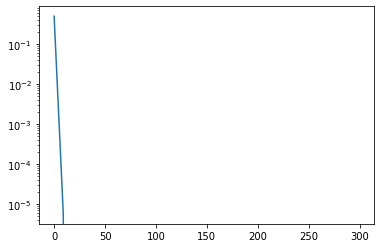

In [116]:
A = np.array([[5,-1,0],[-1,5,-1],[0,-1,5]]) # Strictly diagonal dominant matrix
b = np.ones((N,1))
x,RES,D,L,U = jacobi(A,b,np.zeros([N,1]),1e-5)
plt.semilogy(RES)

## Explicit Jacobi

$$ 
x_j^{(k+1)} = \frac{1}{a_{jj}} \Big( b_j - \sum_{i=1}^{j-1} a_{ji}x_i^{(k)} - \sum_{i=j+1}^n a_{ji}x_i^{(k)} \Big) 
$$

In [121]:
def explicit_jacobi(A,b,x,tol):
    # explicit_gseidel solves the system Ax = b
    # Inputs
    #       A: n-by-n matrix
    #       U: n-by-n Upper triangular matrix
    #       L: n-by-n Lower triangular matrix
    #       D: n-by-n Diagonal matrix
    #       x: initial solution vector
    #       b: n-by-1 coefficient vector
    #       tol: tolerance for stopping criteria
    # Outputs
    #       x: n-by-1 solution vector
    #      RES: residual
    maxiter=300
    N=np.shape(A)[0]
    b=np.reshape(b,[N,1]) 
    RES =np.zeros([maxiter,1])
    res=1
    x=np.reshape(x,[N,1])
    k=0
    while res>tol and k<maxiter:
        k=k+1
        for j in np.arange(0,N):
            x[j] = (b[j] - A[j,j+1::].dot(x[j+1::]) - A[j,0:j].dot(x[0:j]))/A[j,j]
        res = np.linalg.norm(b.reshape(N,1)- (A.dot(x)).reshape(N,1))
        RES[k-1,0]=res
        print(k,'...',res)
    return x,RES

### Testing

1 ... 0.34511447376196785
2 ... 0.0603723910409386
3 ... 0.004829791283275144
4 ... 0.00038638330266197227
5 ... 3.091066421320687e-05
6 ... 2.472853137210704e-06


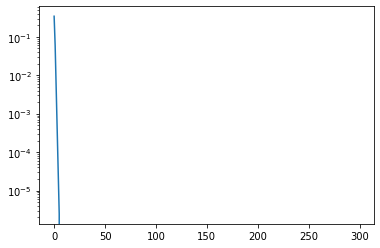

In [122]:
A = np.array([[5,-1,0],[-1,5,-1],[0,-1,5]]) # Strictly diagonal dominant matrix
b = np.ones((N,1))
x,RES = explicit_gseidel(A,b,np.zeros([N,1]),1e-5)
plt.semilogy(RES)

## Gauss-Seidel

$$Ax = b$$

where the matrix A can be decomposed into a lower triangular matrix $L$, a diagonal matrix $D$, and an upper triangular matrix $U$ as follows:

$$A = L+D+U$$

The iterative solution vector becomes:

$$x^{k+1}= -(L+D)^{-1}Ux^{k}+ (L+D)^{-1}b$$

In [75]:
def gseidel(A,b,x,tol):
    # gseidel solves the system Ax = b
    # Inputs
    #       A: n-by-n matrix
    #       U: n-by-n Upper triangular matrix
    #       L: n-by-n Lower triangular matrix
    #       D: n-by-n Diagonal matrix
    #       x: initial solution vector
    #       b: n-by-1 coefficient vector
    #       tol: tolerance for stopping criteria
    # Outputs
    #       x: n-by-1 solution vector
    #      RES: residual
    maxiter=300
    N=np.shape(A)[0]
    b=np.reshape(b,[N,1]) 
    U=sp.triu(A,1)
    U=sp.csr_matrix(U)
    RES =np.zeros([maxiter,1]) 
    DL = sp.tril(A) #L+D
    DL=sp.csr_matrix(DL)
    c=np.reshape(s_prog(DL ,b),[N,1])
    res=1 
    x=np.reshape(x,[N,1])
    k=0
    while res>tol and k<maxiter:
        k=k+1
        ld = U.dot(x) # U@x
        x= -1 * (s_prog(DL ,ld)) + c
        res = np.linalg.norm(b.reshape(N,1)- (A.dot(x)).reshape(N,1))
        RES[k-1,0]=res    
        print(k,'...',res)
    return x,RES

### Testing

1 ... 1.1524430571616109
2 ... 0.6987712429686843
3 ... 0.34938562148434216
4 ... 0.17469281074217108
5 ... 0.08734640537108554
6 ... 0.04367320268554277
7 ... 0.021836601342771385
8 ... 0.010918300671385692
9 ... 0.005459150335692846
10 ... 0.002729575167846423
11 ... 0.0013647875839232116
12 ... 0.0006823937919616058
13 ... 0.0003411968959808029
14 ... 0.00017059844799040144
15 ... 8.529922399520072e-05
16 ... 4.264961199760036e-05
17 ... 2.132480599880018e-05
18 ... 1.066240299940009e-05
19 ... 5.331201499700045e-06


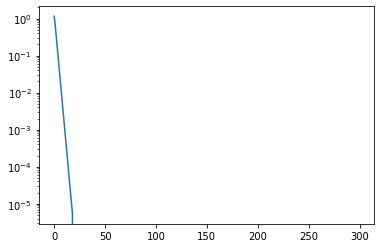

In [76]:
A = np.array([[2,-1,0],[-1,2,-1],[0,-1,2]]) # Positive definite matrix
b = np.ones((N,1))
x,RES = gseidel(A,b,np.zeros([N,1]),1e-5)
plt.semilogy(RES)

## Explicit Gauss-Seidel

$$ 
x_j^{(k+1)} = \frac{1}{a_{jj}} \Big( b_j- \sum_{i=j+1}^n a_{ji}x_i^{(k)} - \sum_{i=1}^{j-1} a_{ij}x_i^{(k+1)} \Big) 
$$

In [77]:
def explicit_gseidel(A,b,x,tol):
    # explicit_gseidel solves the system Ax = b
    # Inputs
    #       A: n-by-n matrix
    #       U: n-by-n Upper triangular matrix
    #       L: n-by-n Lower triangular matrix
    #       D: n-by-n Diagonal matrix
    #       x: initial solution vector
    #       b: n-by-1 coefficient vector
    #       tol: tolerance for stopping criteria
    # Outputs
    #       x: n-by-1 solution vector
    #      RES: residual
    maxiter=300
    N=np.shape(A)[0]
    b=np.reshape(b,[N,1]) 
    RES =np.zeros([maxiter,1])
    res=1
    x=np.reshape(x,[N,1])
    k=0
    while res>tol and k<maxiter:
        k=k+1
        for j in np.arange(0,N):
            x[j] = (b[j] - A[j,j+1::].dot(x[j+1::]) - A[0:j,j].T.dot(x[0:j]))/A[j,j]
        res = np.linalg.norm(b.reshape(N,1)- (A.dot(x)).reshape(N,1))
        RES[k-1,0]=res
        print(k,'...',res)
    return x,RES

### Testing

1 ... 1.1524430571616109
2 ... 0.6987712429686843
3 ... 0.34938562148434216
4 ... 0.17469281074217108
5 ... 0.08734640537108554
6 ... 0.04367320268554277
7 ... 0.021836601342771385
8 ... 0.010918300671385692
9 ... 0.005459150335692846
10 ... 0.002729575167846423
11 ... 0.0013647875839232116
12 ... 0.0006823937919616058
13 ... 0.0003411968959808029
14 ... 0.00017059844799040144
15 ... 8.529922399520072e-05
16 ... 4.264961199760036e-05
17 ... 2.132480599880018e-05
18 ... 1.066240299940009e-05
19 ... 5.331201499700045e-06


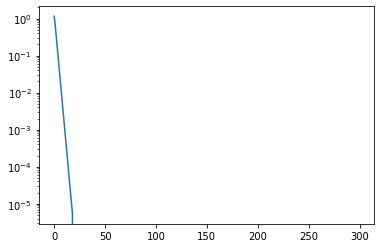

In [78]:
A = np.array([[2,-1,0],[-1,2,-1],[0,-1,2]]) # Positive definite matrix
b = np.ones((N,1))
x,RES = explicit_gseidel(A,b,np.zeros([N,1]),1e-5)
plt.semilogy(RES)

## SOR

$$Ax = b$$

where the matrix A can be decomposed into a lower triangular matrix $L$, a diagonal matrix $D$, and an upper triangular matrix $U$ as follows:

$$A = L+D+U$$

The iterative solution vector becomes:

$$x^{k+1}= -w\left[(L+D)^{-1}Ux^{k}+ (L+D)^{-1}b\right] + (1-w)x^{k}$$

where $w \in (0,1)$

In [79]:
def sor(A,b,x,w,tol):
    # gseidel solves the system Ax = b
    # Inputs
    #       A: n-by-n matrix
    #       U: n-by-n Upper triangular matrix
    #       L: n-by-n Lower triangular matrix
    #       D: n-by-n Diagonal matrix
    #       x: initial solution vector
    #       b: n-by-1 coefficient vector
    #       w: weight between 0 and 1
    #       tol: tolerance for stopping criteria
    # Outputs
    #       x: n-by-1 solution vector
    #      RES: residual
    maxiter=300
    N=np.shape(A)[0]
    b=np.reshape(b,[N,1]) 
    U=sp.triu(A,1)
    U=sp.csr_matrix(U)
    RES =np.zeros([maxiter,1]) 
    DL = sp.tril(A) #L+D
    DL=sp.csr_matrix(DL)
    c=np.reshape(s_prog(DL ,b),[N,1])
    res=1 
    x=np.reshape(x,[N,1])
    k=0
    while res>tol and k<maxiter:
        k=k+1
        ld = U.dot(x) # U@x
        x= -w * (s_prog(DL ,ld)) + (1-w)*x + w*c
        res = np.linalg.norm(b.reshape(N,1)- (A.dot(x)).reshape(N,1))
        RES[k-1,0]=res    
        print(k,'...',res)
    return x,RES

### Test

1 ... 1.3764197215965774
2 ... 1.122066487836171
3 ... 0.9085789712899548
4 ... 0.7260142893580338
5 ... 0.5724958145621614
6 ... 0.44627429178114514
7 ... 0.3446252328817975
8 ... 0.26416224860162124
9 ... 0.20133248223680017
10 ... 0.15278485811932765
11 ... 0.11557032725527908
12 ... 0.08721249636812675
13 ... 0.0656984411551898
14 ... 0.049429095593066824
15 ... 0.03715476907121378
16 ... 0.027910186987968603
17 ... 0.020956004966264218
18 ... 0.01572933743477737
19 ... 0.011803494229253145
20 ... 0.008856027859278278
21 ... 0.006643805085243375
22 ... 0.004983786128114008
23 ... 0.003738325832286331
24 ... 0.0028039975204622717
25 ... 0.00210312972327665
26 ... 0.0015774155872390933
27 ... 0.0011830970888920555
28 ... 0.0008873411412208661
29 ... 0.0006655153307725173
30 ... 0.0004991413917700809
31 ... 0.00037435856879310293
32 ... 0.0002807702281342378
33 ... 0.00021057834139730867
34 ... 0.00015793410095912605
35 ... 0.00011845075305628601
36 ... 8.883815590117042e-05
37 ... 6.

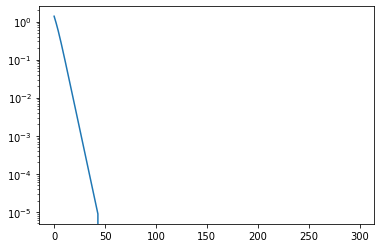

In [80]:
A = np.array([[2,-1,0],[-1,2,-1],[0,-1,2]]) # Positive definite matrix
b = np.ones((N,1))
x,RES = sor(A,b,np.zeros([N,1]),0.5,1e-5)
plt.semilogy(RES)

## Explicit SOR

$$ 
x_j^{(k+1)} = \frac{w}{a_{jj}} \Big( b_j- \sum_{i=j+1}^n a_{ji}x_i^{(k)} - \sum_{i=1}^{j-1} a_{ij}x_i^{(k+1)} \Big) + (1-w)x_j^{(k)}
$$

In [81]:
def explicit_sor(A,b,x,w,tol):
    # explicit_gseidel solves the system Ax = b
    # Inputs
    #       A: n-by-n matrix
    #       U: n-by-n Upper triangular matrix
    #       L: n-by-n Lower triangular matrix
    #       D: n-by-n Diagonal matrix
    #       x: initial solution vector
    #       b: n-by-1 coefficient vector
    #       tol: tolerance for stopping criteria
    # Outputs
    #       x: n-by-1 solution vector
    #      RES: residual
    maxiter=300
    N=np.shape(A)[0]
    b=np.reshape(b,[N,1]) 
    RES =np.zeros([maxiter,1])
    res=1
    x=np.reshape(x,[N,1])
    k=0
    while res>tol and k<maxiter:
        k=k+1
        for j in np.arange(0,N):
            x[j] = w*(b[j] - A[j,j+1::].dot(x[j+1::]) - A[0:j,j].T.dot(x[0:j]))/A[j,j] + (1-w)*x[j]
        res = np.linalg.norm(b.reshape(N,1)- (A.dot(x)).reshape(N,1))
        RES[k-1,0]=res
        print(k,'...',res)
    return x,RES

### Test

1 ... 1.4139545884238998
2 ... 1.170554268772951
3 ... 0.9682844027556695
4 ... 0.7991071863000322
5 ... 0.6581618504629729
6 ... 0.5412816488898753
7 ... 0.44471634304580665
8 ... 0.36514331531902355
9 ... 0.29968613701835045
10 ... 0.24590058572885234
11 ... 0.20173638253028311
12 ... 0.16548816332955152
13 ... 0.13574502791346268
14 ... 0.11134358548770015
15 ... 0.0913265116572411
16 ... 0.07490704672404304
17 ... 0.061439108391135644
18 ... 0.050392389629486334
19 ... 0.04133173842062671
20 ... 0.03390014690845351
21 ... 0.027804749963163858
22 ... 0.022805316629600964
23 ... 0.0187047985415877
24 ... 0.01534157161392455
25 ... 0.012583069636287626
26 ... 0.010320561040352009
27 ... 0.008464864062829208
28 ... 0.006942831961347211
29 ... 0.0056944700161846015
30 ... 0.004670570815558967
31 ... 0.0038307746823014028
32 ... 0.0031419788231215784
33 ... 0.002577032510147498
34 ... 0.0021136668704907894
35 ... 0.0017336171029428955
36 ... 0.0014219025237770337
37 ... 0.001166236063807

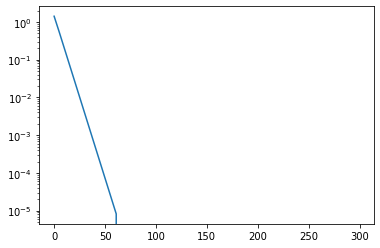

In [82]:
A = np.array([[2,-1,0],[-1,2,-1],[0,-1,2]]) # Positive definite matrix
b = np.ones((N,1))
x,RES = explicit_sor(A,b,np.zeros([N,1]),0.5,1e-5)
plt.semilogy(RES)